In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [5]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

The Data
This anonymized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled in programs focused on supporting listening and spoken language development. Researchers are interested in discovering factors related to improvements in educational outcomes within these programs.

There is a suite of available predictors, including:

gender (male)

number of siblings in the household (siblings)

index of family involvement (family_inv)

whether the primary household language is not English (non_english)

presence of a previous disability (prev_disab)

non-white race (non_white)

age at the time of testing (in months, age_test)

whether hearing loss is not severe (non_severe_hl)

whether the subject’s mother obtained a high school diploma or better (mother_hs)

whether the hearing impairment was identified by 3 months of age (early_ident).

The outcome variable is a standardized test score in one of several learning domains.

In [6]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


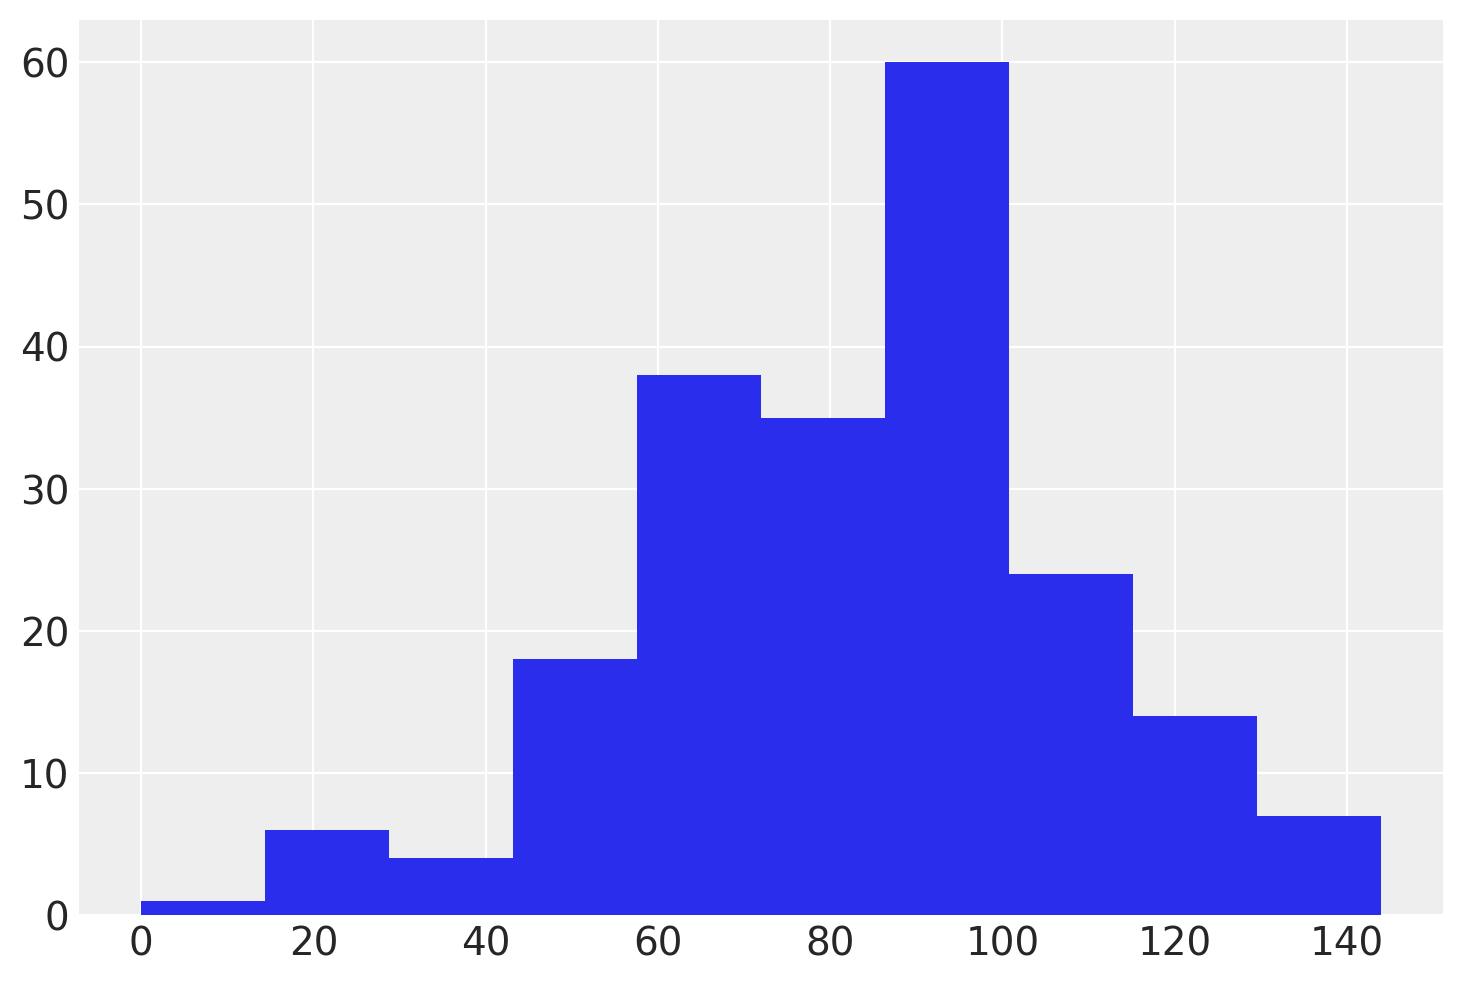

In [7]:
test_scores["score"].hist();

In [8]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

## The Model

This is a more realistic problem than the first regression example, as we are now dealing with a **multivariate regression** model. However, while there are several potential predictors in the LSL-DR dataset, it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes.

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses two regularization strategies, one global and a set of local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

The horseshoe prior for each regression coefficient $\beta_i$ looks like this:

$$
\beta_i \sim N\left(0, \tau^2 \cdot \lambda_i^2\right)
$$

where $\sigma$ is the prior on the error standard deviation that will also be used for the model likelihood. Here, $\tau$ is the global shrinkage parameter and $\lambda_i$ is the local shrinkage parameter. Let's start global: for the prior on $\tau$ we will use a Half-StudentT distribution, which is a reasonable choice because it is heavy-tailed.

$$
\tau \sim \text{Half-StudentT}_2\left(\frac{D_0}{D - D_0}, \frac{\sigma}{\sqrt{N}}\right).
$$

One catch is that the parameterization of the prior requires a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of available predictors.

In [9]:
D0 = int(D / 2)

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$
\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.
$$

To complete this specification, we need priors on $\lambda_i$ and $c$; as with the global shrinkage, we use a long-tailed **Half-StudentT**$_2(1)$ on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \text{InverseGamma}(1, 1)$ fits the bill.

### Reparameterization for efficient sampling

Finally, to allow the NUTS sampler to sample the $\beta_i$ more efficiently, we will re-parameterize it as follows:

$$
\begin{align}
z_i &\sim N(0, 1), \\
\beta_i &= z_i \cdot \tau \cdot \tilde{\lambda}_i.
\end{align}
$$

This **non-centered parameterization** is a crucial technique you will encounter frequently in Bayesian modeling. Here's why it matters:

**The problem with the centered parameterization**: If we sampled $\beta_i \sim N(0, \tau^2 \tilde{\lambda}_i^2)$ directly, the sampler would face strong posterior correlations between $\beta_i$ and its scale parameters $\tau$ and $\tilde{\lambda}_i$. When these hyperparameters are uncertain, the posterior geometry becomes a narrow, curved "funnel" that NUTS struggles to explore efficiently.

**How reparameterization helps**: By introducing an auxiliary variable $z_i \sim N(0, 1)$ that is independent of the scale parameters, and then defining $\beta_i$ as a deterministic transformation $\beta_i = z_i \cdot \tau \cdot \tilde{\lambda}_i$, we decouple the sampling:
- The sampler explores $z_i$ on a fixed standard normal distribution (easy geometry)
- The scale parameters $\tau$ and $\tilde{\lambda}_i$ are updated independently
- The correlation structure is broken, eliminating the funnel pathology

**Practical impact**: This transformation typically reduces divergences, improves effective sample size (ESS), and speeds up convergence. The posterior distribution of $\beta_i$ is unchanged—we're just presenting it to the sampler in a form that's easier to navigate.

You will run into this reparameterization pattern in hierarchical models, variational autoencoders, and any setting where a parameter's scale is uncertain. The key diagnostic is: if you see funnel-shaped joint distributions in your trace plots or encounter persistent divergences, try the non-centered parameterization.

We are also going to take advantage of named dimensions in PyMC and ArviZ by passing the input variable names into the model as coordinates called “predictors”. This will allow us to pass this vector of names as a replacement for the shape integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

In [10]:
import pytensor.tensor as pt

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + pt.dot(X.values, beta), sigma, observed=y.values)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(int8, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(int8, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
        fgraph, node, enforce_tracks=enforce_tracks
    )
  File "/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return 

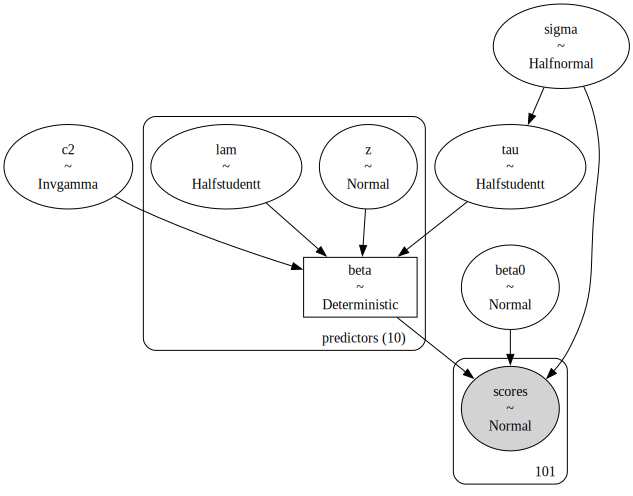

In [11]:
pm.model_to_graphviz(test_score_model)

In [12]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


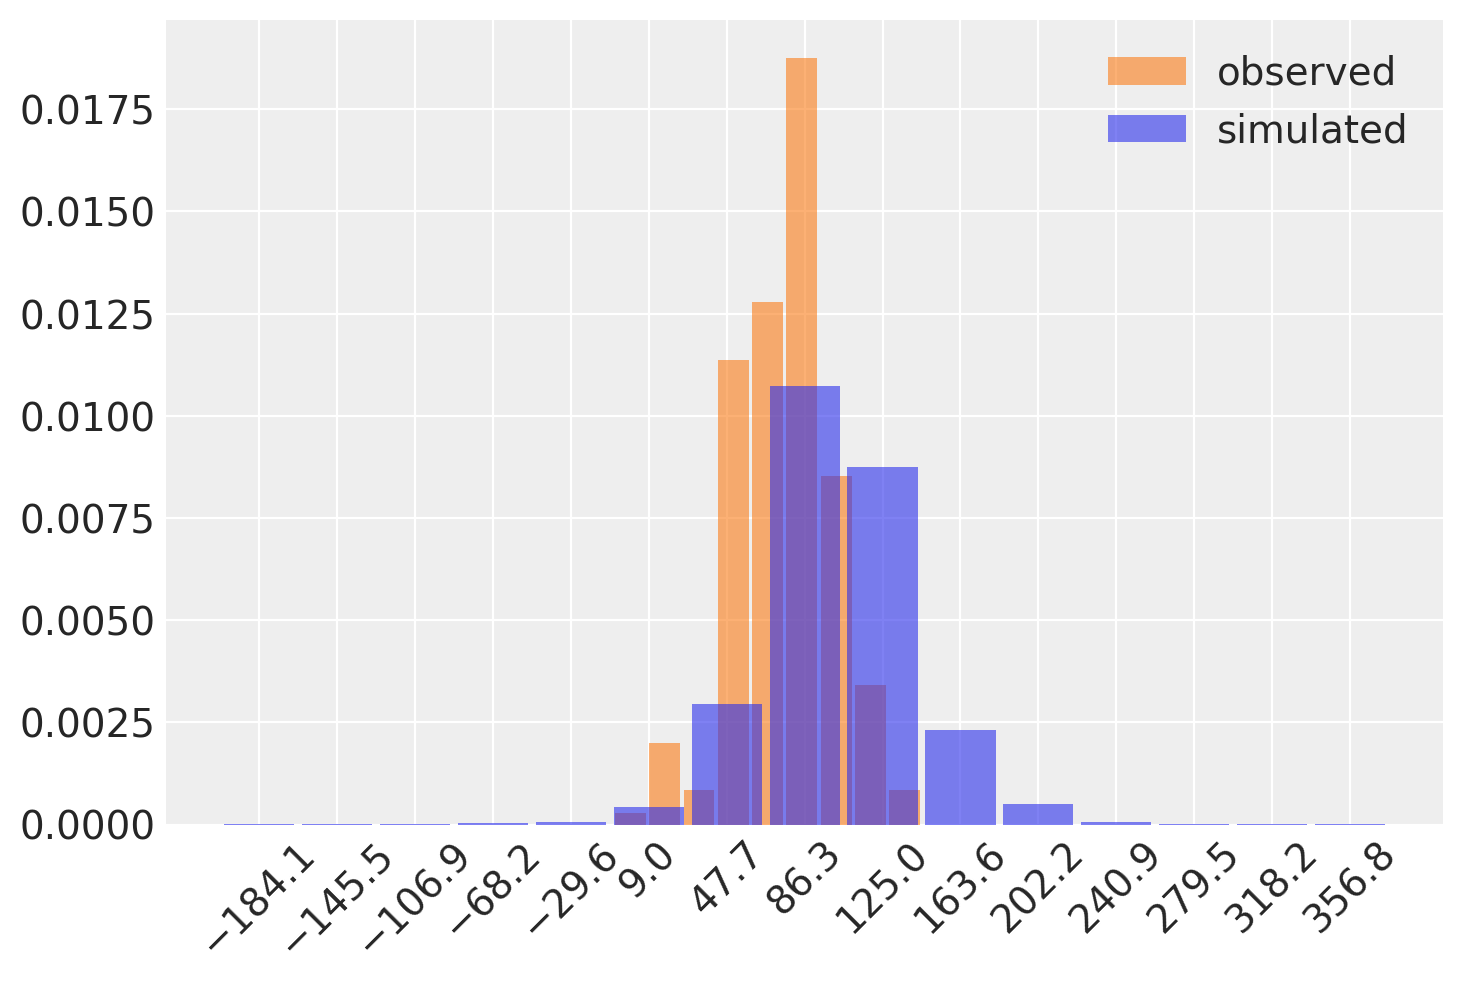

In [13]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
plt.xticks(rotation=45);

In [14]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [15]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

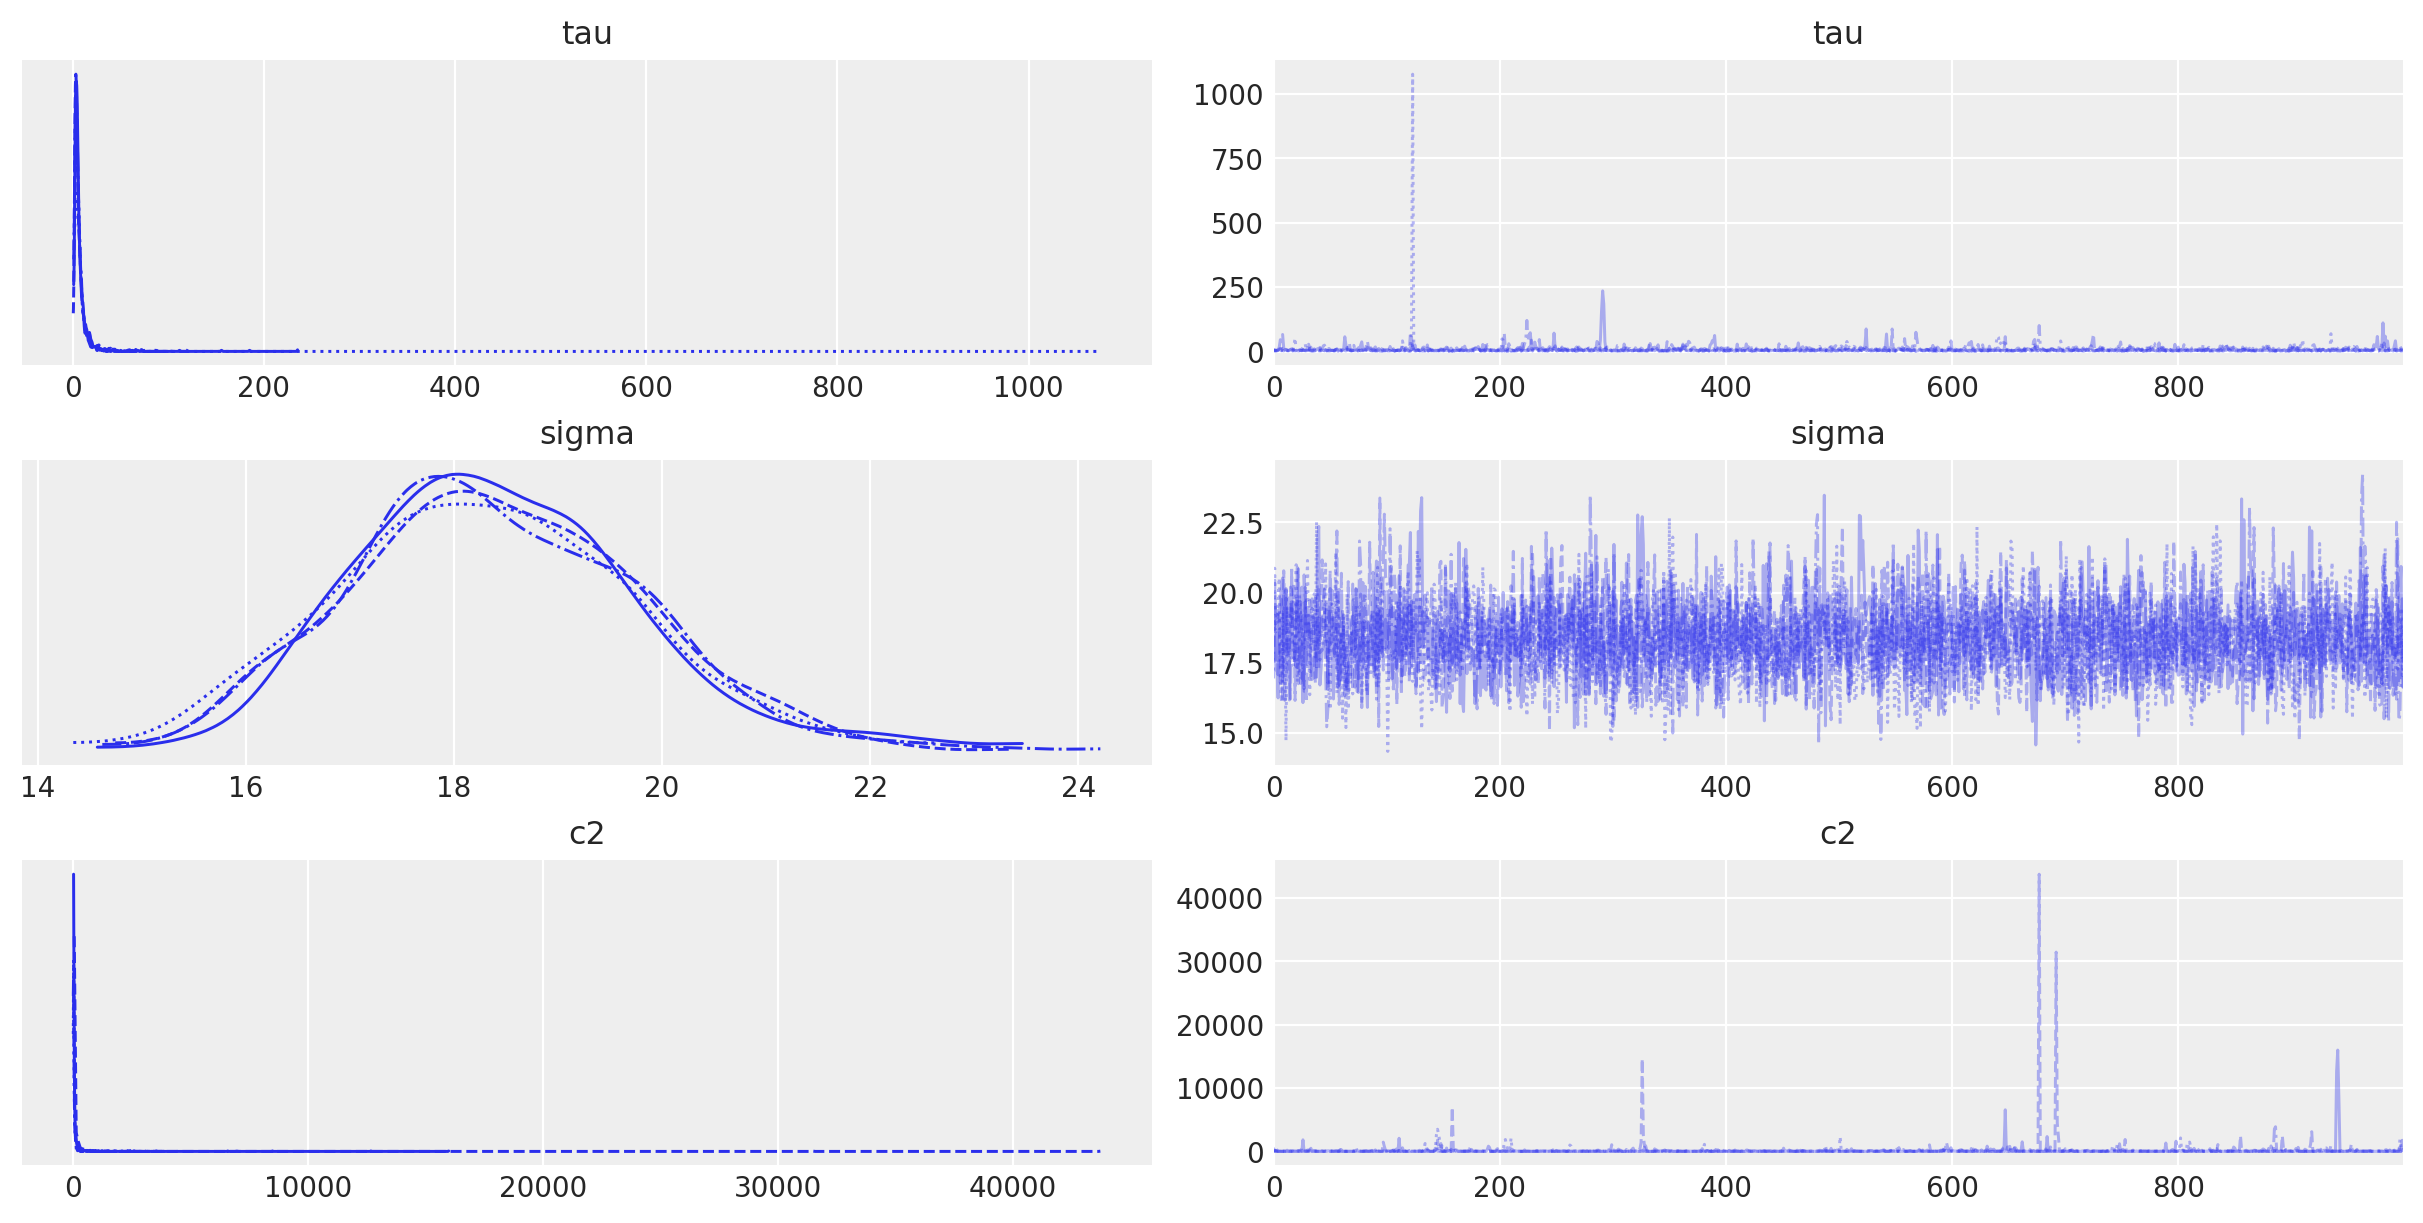

In [16]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"])

<Axes: >

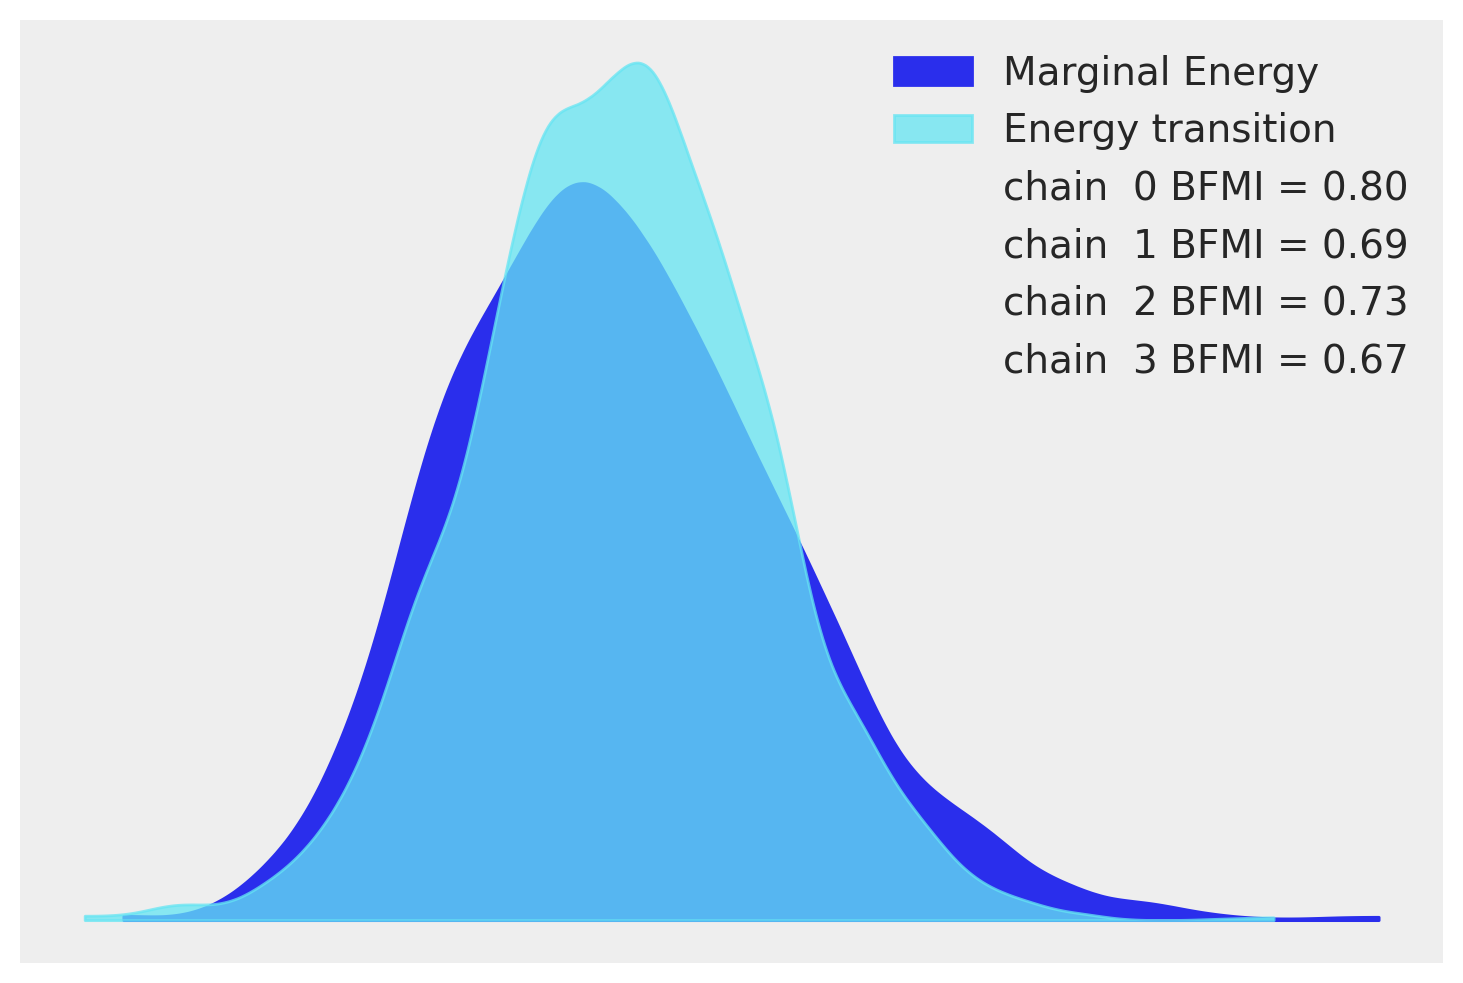

In [17]:
az.plot_energy(idata)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

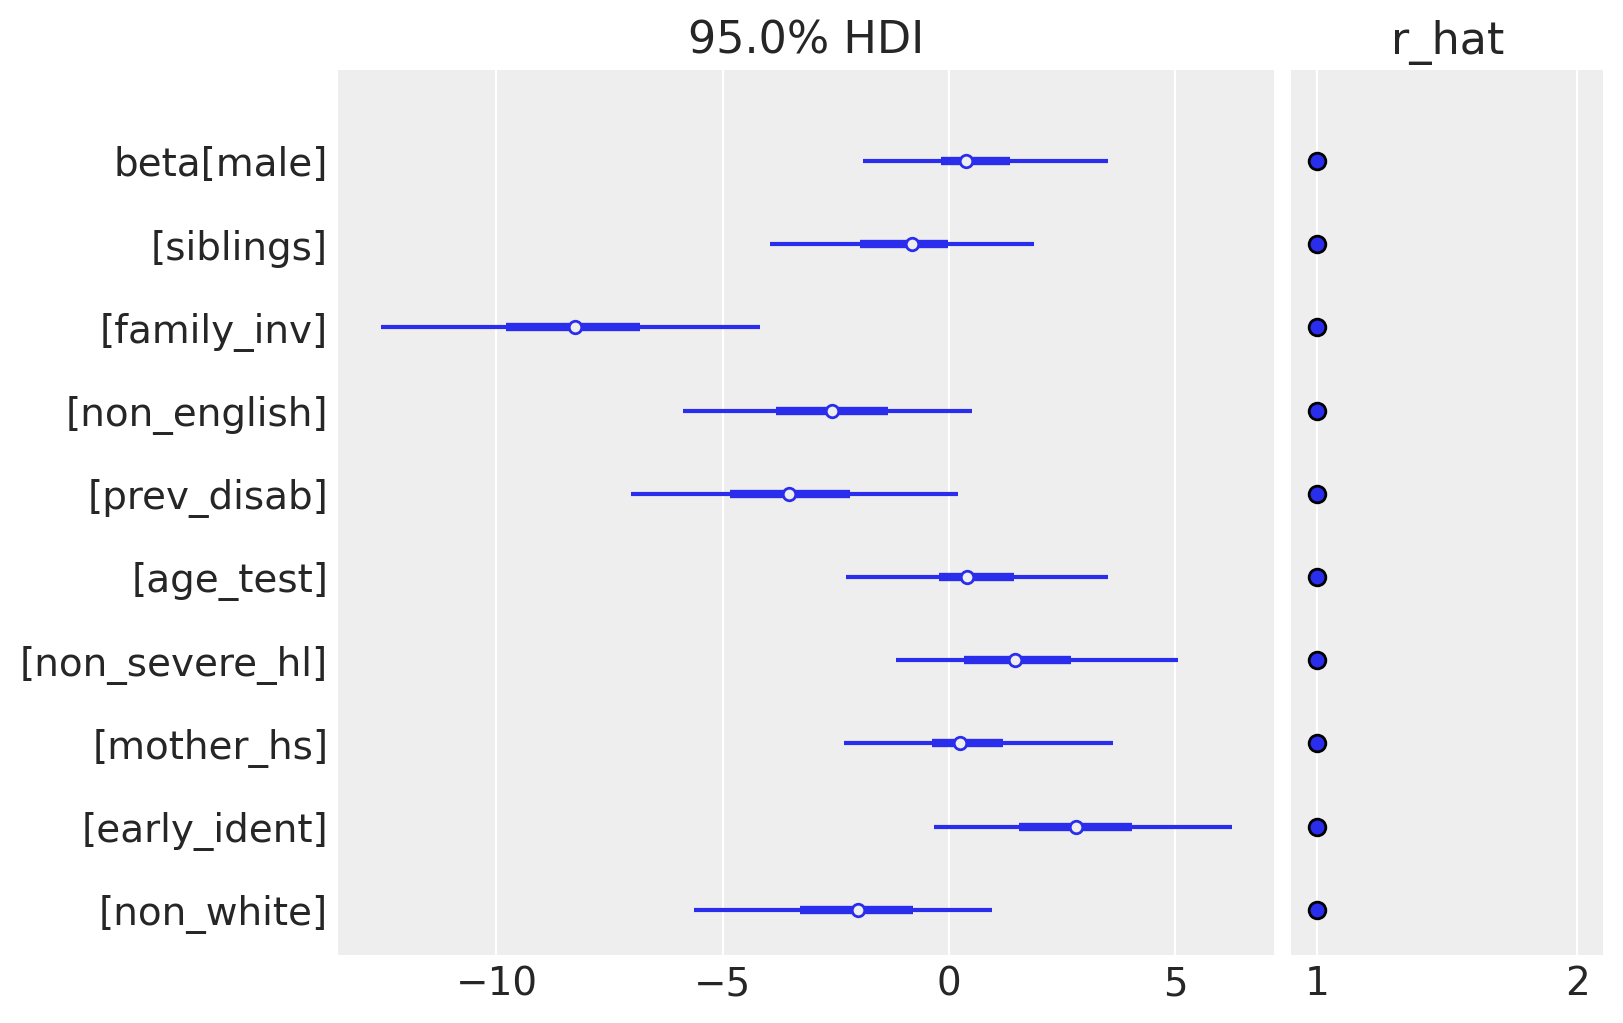

In [18]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

In [19]:
# Save plots for the blog post
import os
os.makedirs("../../static/img/pymc-102", exist_ok=True)

# Save histogram
fig, ax = plt.subplots(figsize=(8, 5))
test_scores["score"].hist(ax=ax, bins=20, edgecolor='black', alpha=0.7)
ax.set_xlabel("Test Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Test Scores")
plt.tight_layout()
plt.savefig("../../static/img/pymc-102/score-histogram.png", dpi=150, bbox_inches='tight')
plt.close()

# Save model graph
graph = pm.model_to_graphviz(test_score_model)
graph.render("../../static/img/pymc-102/model-graph", format='png', cleanup=True)

# Save prior predictive check
fig, ax = plt.subplots(figsize=(10, 5))
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
    ax=ax
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
    ax=ax
)
ax.set_xlabel("Test Score")
ax.set_ylabel("Density")
ax.set_title("Prior Predictive Check")
ax.legend()
plt.tight_layout()
plt.savefig("../../static/img/pymc-102/prior-predictive.png", dpi=150, bbox_inches='tight')
plt.close()

# Save trace plot
fig = az.plot_trace(idata, var_names=["tau", "sigma", "c2"], figsize=(12, 8))
plt.tight_layout()
plt.savefig("../../static/img/pymc-102/trace-plot.png", dpi=150, bbox_inches='tight')
plt.close()

# Save energy plot
fig = az.plot_energy(idata, figsize=(8, 5))
plt.tight_layout()
plt.savefig("../../static/img/pymc-102/energy-plot.png", dpi=150, bbox_inches='tight')
plt.close()

# Save forest plot
fig = az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True, figsize=(8, 10))
plt.tight_layout()
plt.savefig("../../static/img/pymc-102/forest-plot.png", dpi=150, bbox_inches='tight')
plt.close()

print("All plots saved to static/img/pymc-102/")

/tmp/ipykernel_40502/2152876371.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(int8, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
        fgraph, node, enforce_tracks=enforce_tracks
    )
  File "/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/home/dulunche/miniconda3/envs/pymc_env/lib/python3

All plots saved to static/img/pymc-102/


/tmp/ipykernel_40502/2152876371.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [20]:
# Get summary statistics
summary = az.summary(idata, var_names=["beta", "beta0", "tau", "sigma", "c2"], round_to=3)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[male],0.600,1.328,-1.661,3.481,0.020,0.020,4218.433,3346.502,1.001
beta[siblings],-1.023,1.486,-4.007,1.588,0.023,0.021,3968.182,3726.311,1.000
beta[family_inv],-8.293,2.171,-12.506,-4.388,0.037,0.028,3529.820,2930.201,1.002
beta[non_english],-2.623,1.724,-5.780,0.374,0.029,0.022,3564.270,2899.524,1.002
beta[prev_disab],-3.523,1.895,-6.760,0.161,0.032,0.027,3447.723,2059.196,1.001
beta[age_test],0.623,1.415,-1.871,3.636,0.021,0.022,4173.529,3964.174,1.001
beta[non_severe_hl],1.618,1.637,-1.249,4.690,0.028,0.021,3107.554,3049.922,1.000
beta[mother_hs],0.400,1.428,-2.307,3.340,0.021,0.021,4519.631,3932.810,1.000
beta[early_ident],2.849,1.774,-0.243,6.106,0.032,0.025,2955.042,1804.247,1.001
beta[non_white],-2.126,1.768,-5.568,0.769,0.030,0.024,3264.932,3045.278,1.002
